# Benchmark for querying the MovieLens dataset using pandas and bcolz

This benchmark has been run on a Xeon E3-1245 v5 @ 3.50GHz (Skylake, 4 physical cores) with Ubuntu Linux 16.04.  The virtual machine for bcolz is numexpr.

In [1]:
import os.path
import numpy as np
import pandas as pd
import bcolz
from time import time

In [2]:
bcolz.print_versions()

-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
bcolz version:     1.1.1.dev16
NumPy version:     1.11.1
Blosc version:     1.9.3 ($Date:: 2016-07-06 #$)
Blosc compressors: ['blosclz', 'lz4', 'lz4hc', 'snappy', 'zlib']
Numexpr version:   2.6.1
Dask version:      0.10.1
Python version:    2.7.12 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:42:40) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Platform:          linux2-x86_64
Byte-ordering:     little
Detected cores:    8
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


## Import the CSV files in a pandas dataframe

In [3]:
# Files where the data is (using the 10M dataset here)
dset = 'ml-10m'
ftags = os.path.join(dset, 'tags.dat')
fdata = os.path.join(dset, 'ratings.dat.gz')
fitem = os.path.join(dset, 'movies.dat')

zdset = 'ml-10m.blz'
pdset = 'ml-10m.h5'

In [4]:
# Global settings for bcolz and pandas (for experimenting, modify some of the lines below)
bcolz.defaults.cparams['cname'] = 'blosclz'
bcolz.defaults.cparams['clevel'] = 1
bcolz.defaults.eval_vm = "numexpr"
#bcolz.blosc_set_nthreads(4)
#bcolz.numexpr.set_num_threads(4)
# from pandas.computation import expressions as expr
# expr.set_use_numexpr(True)
# expr.set_numexpr_threads(1)

In [5]:
# Load the ratings in a pandas dataframe
t0 = time()
# pass in column names for each CSV
t_cols = ['user_id', 'movie_id', 'tag', 'unix_timestamp']
tags = pd.read_csv(ftags, sep=';', names=t_cols)
#print("Info for tags:", tags.info())

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(fdata, sep=';', names=r_cols, compression='gzip')

m_cols = ['movie_id', 'title', 'genres']
movies = pd.read_csv(fitem, sep=';', names=m_cols,
                     dtype={'title': "S100", 'genres': "S100"})
print("Time for parsing the data: %.2f" % (time()-t0,)) 

t0 = time()
# create one merged DataFrame
movie_ratings = pd.merge(movies, ratings)
# You probably need more than 8 GB in RAM for the next merge
#lens = pd.merge(movie_ratings, tags, on='user_id')
lens = movie_ratings
print("Time for dataframe merges: %.2f" % (time()-t0,)) 
print("Info for movie_ratings:", movie_ratings.info())
print("Info for lens:", lens.info())

Time for parsing the data: 2.94
Time for dataframe merges: 0.68
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000054 entries, 0 to 10000053
Data columns (total 6 columns):
movie_id          int64
title             object
genres            object
user_id           int64
rating            float64
unix_timestamp    int64
dtypes: float64(1), int64(3), object(2)
memory usage: 534.1+ MB
('Info for movie_ratings:', None)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000054 entries, 0 to 10000053
Data columns (total 6 columns):
movie_id          int64
title             object
genres            object
user_id           int64
rating            float64
unix_timestamp    int64
dtypes: float64(1), int64(3), object(2)
memory usage: 534.1+ MB
('Info for lens:', None)


## Compute the size of the dataframe, taking in account the true object overhead

In [6]:
# Size of the dataframe in-memory
rsize = lens.values.nbytes / 2**20.
print("Size for regular values in lens dataframe: %.1f MB" % (rsize,))

Size for regular values in lens dataframe: 457.8 MB


In [7]:
# Compute the overhead of the objects in dataframe
dfo = lens.blocks['object']
import sys
overhead = sum(sys.getsizeof(o) for o in dfo.values.flat) / 2**20.
print("Overhead of objects: %.1f MB" % (overhead ,))

Overhead of objects: 1115.1 MB


In [8]:
# Total size:
dfsize = rsize + overhead
print("Total size for the dataframe: %.1f MB" % (dfsize,))

Total size for the dataframe: 1572.8 MB


## Querying with pandas

In [9]:
# Simple query
t0 = time()
result = lens[lens['title'] == b'Tom and Huck (1995)']
#result = lens.query("title == 'Tom and Huck (1995)'")
dfsmplqtime = time() - t0
print("time (and length) for simple query with pandas: %.2f (%d)" %
      (dfsmplqtime, len(result)))
#print repr(result)

time (and length) for simple query with pandas: 0.16 (899)


In [10]:
# Complex query
t0 = time()
result = lens[(lens['title'] == b'Tom and Huck (1995)') & (lens['rating'] == 5)]['user_id']
#result = lens.query("(title == 'Tom and Huck (1995)') & (rating == 5)")['user_id']
dfcmplxqtime = time() - t0
print("time (and length) for complex query with pandas: %.2f (%d)" %
      (dfcmplxqtime, len(result)))

time (and length) for complex query with pandas: 0.18 (74)


## Build a ctable out of the dataframe

In [11]:
# Get a bcolz ctable out of the lens dataframe (using compression by default)
t0 = time()
zlens = bcolz.ctable.fromdataframe(lens)
print("time for ctable conversion: %.2f" % (time()-t0))
#print repr(zlens)

time for ctable conversion: 0.94


In [12]:
# Get rid of the dataframe to cleanup memory
del lens

In [13]:
# Size for the compressed ctable
zsize = zlens.cbytes / 2**20.
print("Total size for the ctable: %.1f MB" % (zsize,))
# Compression ratio
print("Compression ratio the ctable: %.1fx" % (zlens.nbytes / float(zlens.cbytes),))
# Reduction in size compared with the dataframe
print("Storage savings compared with a dataframe: %.1fx" % (dfsize / zsize,))

Total size for the ctable: 92.7 MB
Compression ratio the ctable: 19.8x
Storage savings compared with a dataframe: 17.0x


## Query the ctable

In [14]:
# Simple query
t0 = time()
result = zlens["title == 'Tom and Huck (1995)'"]
zsmplqtime = time() - t0
print("time (and length) for simple query with bcolz: %.2f (%d)" %
      (zsmplqtime, len(result)))
#print repr(result)

time (and length) for simple query with bcolz: 0.08 (899)


In [15]:
# Complex query
t0 = time()
#result = zlens["(title == 'Tom and Huck (1995)') & (rating == 5)"]['user_id']
result = [r.user_id for r in zlens.where(
    "(title == 'Tom and Huck (1995)') & (rating == 5)", outcols=['user_id'])]
zcmplxqtime = time() - t0
print("time (and length) for complex query with bcolz: %.2f (%d)" %
      (zcmplxqtime, len(result)))
#print(repr(result))

time (and length) for complex query with bcolz: 0.09 (74)


## Testing an uncompressed ctable

In [16]:
# Size for the uncompressed ctable
nzlens = zlens.copy(cparams=bcolz.cparams(clevel=0))
nzsize = nzlens.cbytes / 2**20.
print("Total size for the ctable: %.1f MB" % (nzsize,))
# Compression ratio
print("Compression ratio the ctable: %.1fx" % (nzlens.nbytes / float(nzlens.cbytes),))
# Reduction in size compared with the dataframe
print("Storage savings compared with a dataframe: %.1fx" % (dfsize / nzsize,))

Total size for the ctable: 1833.0 MB
Compression ratio the ctable: 1.0x
Storage savings compared with a dataframe: 0.9x


In [17]:
# Time for a simple query with the uncompressed ctable
t0 = time()
result = nzlens["title == 'Tom and Huck (1995)'"]
nzsmplqtime = time() - t0
print("time (and length) for simple query with bcolz: %.2f (%d)" %
      (nzsmplqtime, len(result)))
#print repr(result)

time (and length) for simple query with bcolz: 0.14 (899)


In [18]:
# Time for a complex query with the uncompressed ctable
t0 = time()
#result = zlens["(title == 'Tom and Huck (1995)') & (rating == 5)"]['user_id']
result = [r.user_id for r in nzlens.where(
    "(title == 'Tom and Huck (1995)') & (rating == 5)", outcols=['user_id'])]
nzcmplxqtime = time() - t0
print("time (and length) for complex query with bcolz: %.2f (%d)" %
      (nzcmplxqtime, len(result)))

time (and length) for complex query with bcolz: 0.14 (74)


In [19]:
# Get rid of previous dataset to clean up memory
del nzlens

## Testing a disk-based ctable

In [20]:
# Size for a disk-based ctable
fname = "ctable-10m.bcolz"
import shutil
if os.path.exists(fname):
    shutil.rmtree(fname)
dblens = zlens.copy(rootdir=fname)
# "du -sh "ctable-10m.bcolz"
dbsize = dblens.cbytes / 2**20.
print("Total size for the ctable: %.1f MB" % (dbsize,))
# Compression ratio
print("Compression ratio for the ctable: %.1fx" % (dblens.nbytes / float(dblens.cbytes),))
# Reduction in size compared with the dataframe
print("Storage savings compared with a dataframe: %.1fx" % (dfsize / dbsize,))

Total size for the ctable: 92.7 MB
Compression ratio for the ctable: 19.8x
Storage savings compared with a dataframe: 17.0x


In [21]:
!du -sh "ctable-10m.bcolz"

95M	ctable-10m.bcolz


In [22]:
# Time for a simple query with the on-disk ctable
t0 = time()
result = dblens["title == 'Tom and Huck (1995)'"]
dbsmplqtime = time() - t0
print("time (and length) for simple query with on-disk bcolz: %.2f (%d)" %
      (dbsmplqtime, len(result)))
#print repr(result)

time (and length) for simple query with on-disk bcolz: 0.11 (899)


In [23]:
# Time for a complex query with the uncompressed ctable
t0 = time()
#result = dblens["(title == 'Tom and Huck (1995)') & (rating == 5)"]['user_id']
result = [r.user_id for r in dblens.where(
    "(title == 'Tom and Huck (1995)') & (rating == 5)", outcols=['user_id'])]
dbcmplxqtime = time() - t0
print("time (and length) for complex query with on-disk bcolz: %.2f (%d)" %
      (dbcmplxqtime, len(result)))

time (and length) for complex query with on-disk bcolz: 0.12 (74)


## Plots

/home/francesc/miniconda3/envs/py27/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2869: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


/home/francesc/miniconda3/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


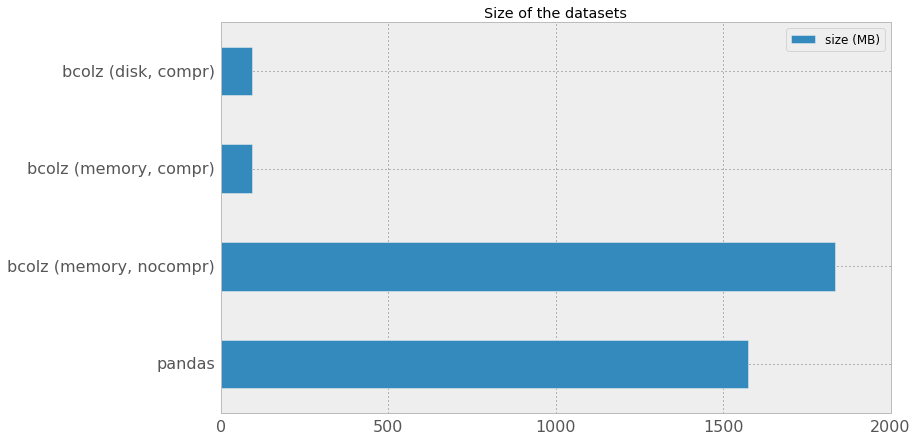

In [24]:
%matplotlib inline
# Sizes
index = ["pandas", "bcolz (memory, nocompr)", "bcolz (memory, compr)", "bcolz (disk, compr)"]
#index = ["bcolz (disk)", "bcolz (compr)", "bcolz (nocompr)", "pandas"]
df = pd.DataFrame({'size (MB)': [dfsize, nzsize, zsize, dbsize]}, index=index)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,7), fontsize=16, title="Size of the datasets")

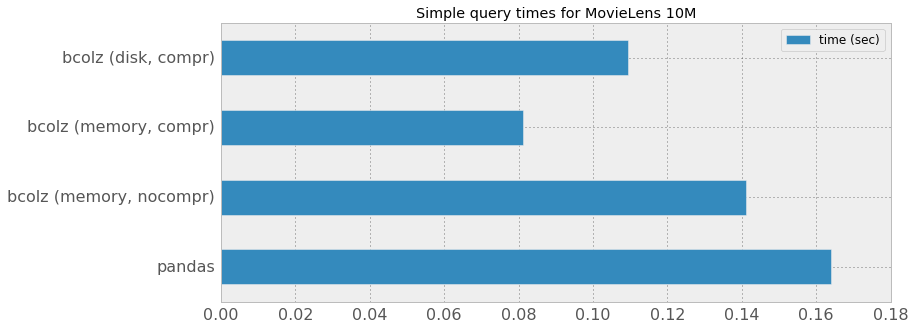

In [25]:
# Simple query times
df = pd.DataFrame({'time (sec)': [dfsmplqtime, nzsmplqtime, zsmplqtime, dbsmplqtime]}, index=index)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Simple query times for MovieLens 10M")

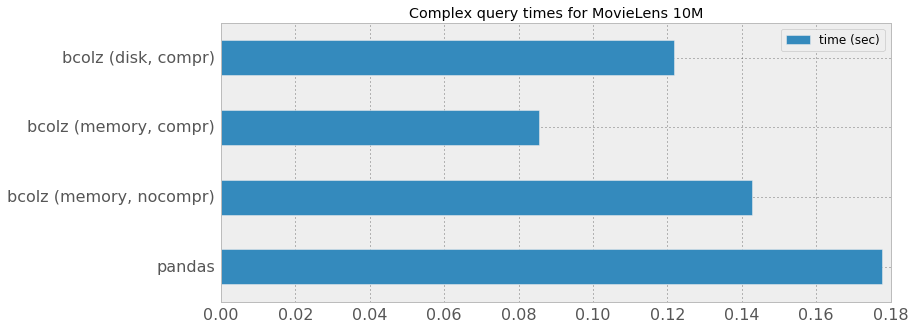

In [26]:
# Complex query times
df = pd.DataFrame({'time (sec)': [dfcmplxqtime, nzcmplxqtime, zcmplxqtime, dbcmplxqtime]}, index=index)
pd.options.display.mpl_style = 'default'
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Complex query times for MovieLens 10M")
